## 03- Entrenamiento del Modelo

En este notebook realizaremos los procedimientos necesarios para entrenar el modelo que permita establecer la probabilidad de que un cliente no renueve su producto con la compañía, basado en las diferentes dimensiones de información que se tengan del mismo al momento de emitir la póliza y que hemos explorado en los notebooks anteriores. Para ello usaremos las ventajas de la librería `scikit-learn`.

In [1]:
from model_parameters import *
import pandas as pd
import numpy as np
from utils import metrics,get_confusion_plot
from sklearn.metrics import roc_auc_score
data=pd.read_csv("data_modelacion.csv",sep=";",dtype={'Asegurado__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str})

## Revisar Balanceo de Datos

Como podemos observar, la proporción de clientes que no renovaron su poliza son mayores respecto a los que si lo hicieron. Este desbalanceo en la data toma importancia al momento de analizar las métricas de un modelo. Por tanto, es vital utilizar métricas que no sean sensibles al desbalanceo de clases en la información de entrenamiento. Para ello existen además, algunas técnicas como disminuir la información de la clase mayoritaria (undersampling) o incluso generar instancias de la clase minoritaria a partir de algoritmos que utilizan K-nearest neighbors (ver [Adasyn](http://glemaitre.github.io/imbalanced-learn/auto_examples/over-sampling/plot_adasyn.html) o [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html))

In [2]:
data.churn.value_counts(normalize=True)*100

1    68.355814
0    31.644186
Name: churn, dtype: float64

## Generar Particiones de Datos

Se debe generar una partición de la data para test(10%), el restante se usará para entrenamiento y validación.

In [3]:
#Definir esquema para valores faltantes
num_cols=[i for i in data.columns.values.tolist() if data[i].dtype!="O" and i not in ['churn','Profesion__pc','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c','tipo_ramo_name']]
str_cols=[i for i in data.columns.values.tolist() if data[i].dtype not in ["int32","float","int64"] and i not in ['churn','NumeroPoliza__c','Producto__c','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','tipo_ramo_name','Tipo_poliza_c']]
train,test=train_test_split(data, test_size=0.10,random_state=666)

## Downsampling
Para mitigar el desbalanceo de datos, reduciremos la cantidad de instancias de la clase mayoritaria (churn) de la base de entrenamiento en un 20%

In [4]:
churn_dat=train.query("churn==1").sample(frac=0.8)
nochurn_dat=train.query("churn==0")
train=pd.concat((churn_dat,nochurn_dat)).sample(frac=1) ##para que haya un remuestreo de las filas (pasar consecutivamente una clase al modelo en entrenamiento puede traer overfitting)

In [5]:
##guardar train y test para reproducibilidad
train.to_csv("train.csv",sep=";",index=False)
test.to_csv("test.csv",sep=";",index=False)

## Modelos a Evaluar

Se procede a evaluar dos tipos de modelos de tipo boosting (XGboost,LightGBM), los cuales son ampliamente usados en el modelamiento predictivo. A su vez, se prueba un modelo sencillo como la regresión logística, para comparar el desempeño frente a modelos de mayor complejidad. El objetivo general de esta comparación es establecer qué tipo de modelo puede encontrar los aspectos más relevantes para establecer cuándo un cliente tiene mayor propensión a renovar su producto con la compañía.

In [6]:
from sklearn import set_config
set_config(display='diagram')

In [7]:
# La variable punto de venta tiene más de 1300 categorías, por lo tanto, al tener la ciudad de venta recategorizada, se procede a generar la base de entrenamiento de esta en lugar del punto de venta.
X_train,Y_train=train.drop(columns=["churn","Asegurado__c","PuntoVenta__c"]),train['churn'].values

In [8]:
## Pasos de imputación y estandarización

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import FunctionTransformer
##for imbalanced dataset use cohen's kappa como métrica a maximizar

from sklearn.metrics import cohen_kappa_score, make_scorer

kappa_sc=make_scorer(cohen_kappa_score)

def get_classifier_model(model_name:str,k_cv:int=5,scoring=kappa_sc,imputer="zero",scaler_method="standard",one_hot_str=True,pca=True) -> GridSearchCV:
    """retorna un objeto GridSearchCV para entrenar con @param model_name y k_cv-fold Cross Validation
    para clasificación binaria, la métrica de scoring de los modelos está dada por @param scoring
    @param imputer: str | "zero" usa como enfoque de imputación poner 0 a los valores perdidos, otro valor usa el enfoque de asignar la mediana.
    @param scaler_method: str | "standard" define StandardScaler para escalar variables numéricas, minmax lo define como MinMaxScaler, None no imputa los valores
    @param enable_str_tf: Boolean | True activa one-hot-encoding para las variables categóricas
    """

    scl=StandardScaler() if scaler_method=="standard" else MinMaxScaler()

    if imputer=="zero":
        imp=SimpleImputer(strategy="constant",fill_value=0)
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        ) 
    elif imputer=="median":
        imp=SimpleImputer(strategy="median")
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        )
    else:
        num_transformer = Pipeline(
        steps=[("scaler",scl)]
        )

    if one_hot_str:
        cat_transformer = OneHotEncoder(handle_unknown="ignore")
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    else:
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", SimpleImputer(strategy="constant",fill_value="otros"), str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )

    model=MODEL_LIST[model_name]
    

    param_grid=MODEL_PARAMS[model_name]['param_grid'].copy()
    if pca:
        pipe=Pipeline([
            ('cleaner',preprocessor),
            ('pca',PCA()),
            ('model',model)],verbose=True)
    else:
        pipe=Pipeline([
        ('cleaner',preprocessor),
        ('model',model)], verbose=True)
        param_grid.pop("pca__n_components")
    

    grid=GridSearchCV(pipe,param_grid,cv=k_cv,refit=True,scoring=scoring,verbose=True,n_jobs=-1)
    return grid

xgb=get_classifier_model("xgboost")
logistic=get_classifier_model("logistic_regression")
lightgbm=get_classifier_model("lightgbm")

In [9]:
xgb.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=  29.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100],
                         'model__subsample': [1],
                         'pca__n_components': [10, 20]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [10]:
logistic.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   4.7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [11]:
lightgbm.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20],
                         'model__n_estimators': [100, 150],
                         'model__num_leaves': [10, 25],
                         'model__reg_alpha': [0.0, 0.5, 1.1],
                         'pca__n_components': [10, 20]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

## Verificar desempeño de los modelos

A continuación se proponen métricas generales para evaluar el desempeño de los modelos entrenados para las bases de entrenamiento y test.

In [12]:
#diccionario que almacena métricas de evaluación
results={}

In [13]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_zero_std_pca']={'train':metrics(Y_train.ravel(),xgb.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_zero_std_pca']={'train':metrics(Y_train.ravel(),logistic.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),logistic.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_zero_std_pca']={'train':metrics(Y_train.ravel(),lightgbm.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),lightgbm.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.7573 
 Precision: 0.7242 
 Recall: 0.9963 
 Specificity: 0.3446 
 Kappa: 0.3948 
 F1-Score: 0.8387 
ROC-AUC: 0.8526


	 Test 

 Accuracy:0.7525 
 Precision: 0.7469 
 Recall: 0.9656 
 Specificity: 0.2900 
 Kappa: 0.3085 
 F1-Score: 0.8423 
ROC-AUC: 0.7244


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.6120 
 Precision: 0.7052 
 Recall: 0.6656 
 Specificity: 0.5195 
 Kappa: 0.1814 
 F1-Score: 0.6848 
ROC-AUC: 0.6157


	 Test 

 Accuracy:0.6391 
 Precision: 0.7666 
 Recall: 0.6798 
 Specificity: 0.5509 
 Kappa: 0.2163 
 F1-Score: 0.7206 
ROC-AUC: 0.6440


===Métricas para LightGBM===


	 Training

 Accuracy:0.7559 
 Precision: 0.7266 
 Recall: 0.9854 
 Specificity: 0.3595 
 Kappa: 0.3961 
 F1-Score: 0.8364 
ROC-AUC: 0.8388


	 Test 

 Accuracy:0.7549 
 Precision: 0.7495 
 Recall: 0.9641 
 Specificity: 0.3009 
 Kappa: 0.3183 
 F1-Score: 0.8434 
ROC-AUC: 0.7295



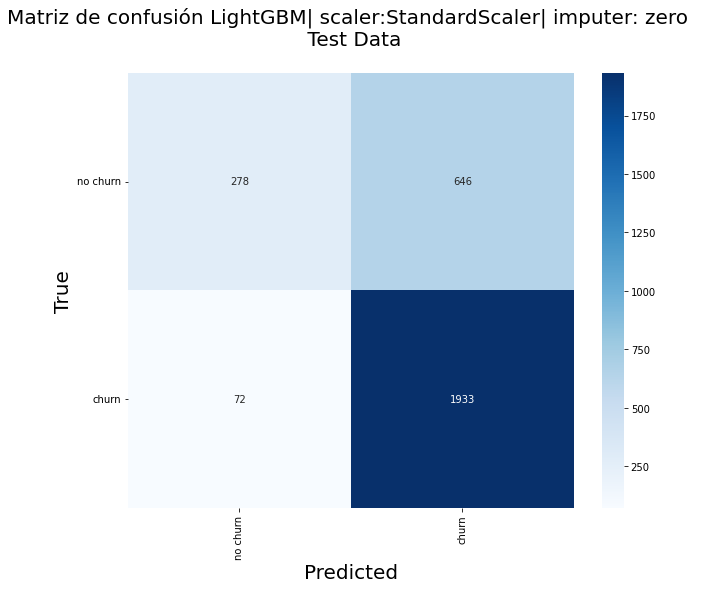

In [14]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),lightgbm.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión LightGBM| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Otros enfoques de entrenamiento

Debido a la gran variedad de modelos y de técnicas para intentar maximizar el desempeño de los mismos, es necesario explorarlas. Dependiendo del enfoque, tiempo disponible u otros factores, se pueden abordar más modelos o modificaciones de los modelos evaluados y comparar los resultados. A continuación intentamos evaluar el desempeño, usando otras técnicas de imputación de datos y enfoque para el escalado de variables numéricas. A su vez, analizamos el desempeño de los modelos al eliminar la reducción de dimensionalidad propuesta a través de Componentes Principales(PCA).


In [15]:
#Modelos con escalado minmax e imputación a través de la mediana
xgb_2=get_classifier_model("xgboost",scaler_method="minmax",imputer="median")
logistic_2=get_classifier_model("logistic_regression",scaler_method="minmax",imputer="median")
lightgbm_2=get_classifier_model("lightgbm",scaler_method="minmax",imputer="median")

In [16]:
xgb_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=  12.3s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100],
                         'model__subsample': [1],
                         'pca__n_components': [10, 20]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [17]:
logistic_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [18]:
lightgbm_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20],
                         'model__n_estimators': [100, 150],
                         'model__num_leaves': [10, 25],
                         'model__reg_alpha': [0.0, 0.5, 1.1],
                         'pca__n_components': [10, 20]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [19]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_median_minmax_pca']={'train':metrics(Y_train.ravel(),xgb_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),xgb_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_median_minmax_pca']={'train':metrics(Y_train.ravel(),logistic_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),logistic_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_median_minmax_pca']={'train':metrics(Y_train.ravel(),lightgbm_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),lightgbm_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.7402 
 Precision: 0.7098 
 Recall: 0.9977 
 Specificity: 0.2955 
 Kappa: 0.3439 
 F1-Score: 0.8295 
ROC-AUC: 0.8105


	 Test 

 Accuracy:0.7532 
 Precision: 0.7441 
 Recall: 0.9746 
 Specificity: 0.2727 
 Kappa: 0.3020 
 F1-Score: 0.8439 
ROC-AUC: 0.7296


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.6352 
 Precision: 0.7116 
 Recall: 0.7130 
 Specificity: 0.5009 
 Kappa: 0.2140 
 F1-Score: 0.7123 
ROC-AUC: 0.6709


	 Test 

 Accuracy:0.6589 
 Precision: 0.7690 
 Recall: 0.7172 
 Specificity: 0.5325 
 Kappa: 0.2402 
 F1-Score: 0.7422 
ROC-AUC: 0.6851


===Métricas para LightGBM===


	 Training

 Accuracy:0.7286 
 Precision: 0.7077 
 Recall: 0.9734 
 Specificity: 0.3058 
 Kappa: 0.3232 
 F1-Score: 0.8196 
ROC-AUC: 0.7658


	 Test 

 Accuracy:0.7532 
 Precision: 0.7483 
 Recall: 0.9636 
 Specificity: 0.2965 
 Kappa: 0.3128 
 F1-Score: 0.8424 
ROC-AUC: 0.7358



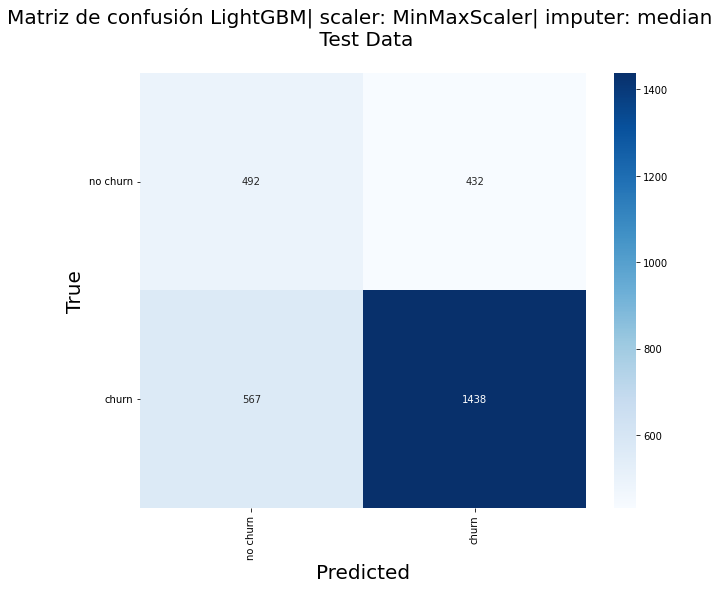

In [20]:
get_confusion_plot(test['churn'].values.ravel(),logistic_2.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión LightGBM| scaler: MinMaxScaler| imputer: median \n Test Data\n")

### Analisis del Performance sin Componentes Principales

In [21]:
xgb_nopca=get_classifier_model("xgboost",pca=False)
logistic_nopca=get_classifier_model("logistic_regression",pca=False)
lightgbm_nopca=get_classifier_model("lightgbm",pca=False)

In [22]:
xgb_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  19.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100],
                         'model__subsample': [1]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [23]:
logistic_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  45.7s


c:\Users\jhonp\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet']},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [24]:
lightgbm_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20],
                         'model__n_estimators': [100, 150],
                         'model__num_leaves': [10, 25],
                         'model__reg_alpha': [0.0, 0.5, 1.1]},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

In [25]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_zero_std_nopca']={'train':metrics(Y_train.ravel(),xgb_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),xgb_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_zero_std_nopca']={'train':metrics(Y_train.ravel(),logistic_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),logistic_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_zero_std_nopca']={'train':metrics(Y_train.ravel(),lightgbm_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),lightgbm_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.8306 
 Precision: 0.7893 
 Recall: 0.9992 
 Specificity: 0.5394 
 Kappa: 0.5963 
 F1-Score: 0.8820 
ROC-AUC: 0.9597


	 Test 

 Accuracy:0.7491 
 Precision: 0.7536 
 Recall: 0.9411 
 Specificity: 0.3323 
 Kappa: 0.3200 
 F1-Score: 0.8370 
ROC-AUC: 0.7164


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.6270 
 Precision: 0.7132 
 Recall: 0.6876 
 Specificity: 0.5224 
 Kappa: 0.2072 
 F1-Score: 0.7001 
ROC-AUC: 0.6240


	 Test 

 Accuracy:0.6559 
 Precision: 0.7726 
 Recall: 0.7047 
 Specificity: 0.5498 
 Kappa: 0.2421 
 F1-Score: 0.7371 
ROC-AUC: 0.6500


===Métricas para LightGBM===


	 Training

 Accuracy:0.7529 
 Precision: 0.7239 
 Recall: 0.9858 
 Specificity: 0.3506 
 Kappa: 0.3874 
 F1-Score: 0.8348 
ROC-AUC: 0.8154


	 Test 

 Accuracy:0.7542 
 Precision: 0.7523 
 Recall: 0.9556 
 Specificity: 0.3171 
 Kappa: 0.3239 
 F1-Score: 0.8418 
ROC-AUC: 0.7417



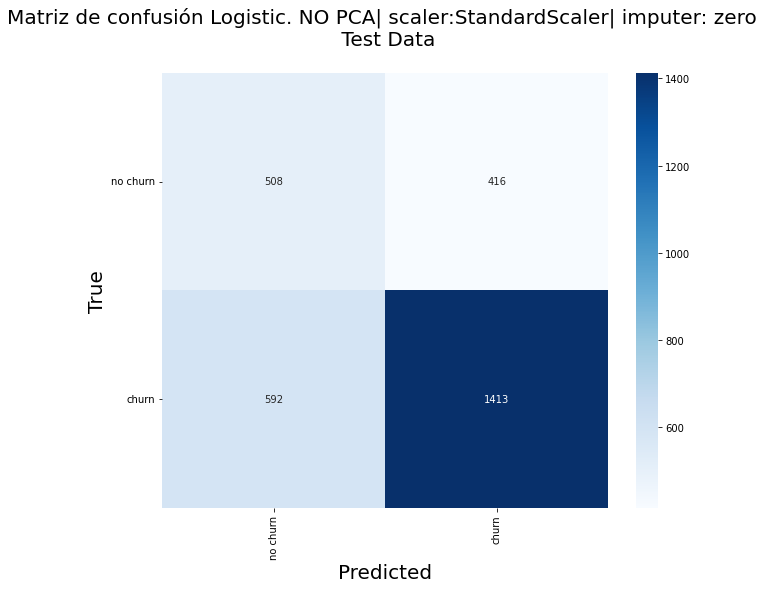

In [26]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),logistic_nopca.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión Logistic. NO PCA| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Stack de Modelos

Una alternativa muy común al tener varios modelos, es el realizar stack de uno o más modelos y realizar una operación que puede partir de promediar hasta generar un nuevo modelo su resultado para obtener una mejor estimación. A continuación se intenta con LightGBM y la Regresión Logística. Además, es posible verificar el performance usando diferentes puntos de corte

In [27]:
def pred_stack(data,proba=True,thresh=0.56):
    proba_lgb=lightgbm.predict_proba(data)[:,1]
    predict_log=logistic.predict_proba(data)[:,1]
    if proba:
        return np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)
    else:
        return (np.stack((proba_lgb,predict_log),axis=1).mean(axis=1)>thresh).astype(int)

In [28]:
## Métricas para stacking usando punto de corte 0.56

print("\n===Métricas para Stacking LightGBM y Logistic ===\n")
print("\n\t Training\n")
results['stack_lightgbm_logistic']={'train':metrics(Y_train.ravel(),pred_stack(X_train,False))}
roc=roc_auc_score(Y_train.ravel(),pred_stack(X_train))
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['stack_lightgbm_logistic']['test']=metrics(test['churn'].values.ravel(),pred_stack(test.drop(columns=["churn","Asegurado__c"]),False))
roc=roc_auc_score(test['churn'].values.ravel(),pred_stack(test.drop(columns=["churn","Asegurado__c"])))
print("ROC-AUC: {:.4f}\n".format(roc))


===Métricas para Stacking LightGBM y Logistic ===


	 Training

 Accuracy:0.7145 
 Precision: 0.7692 
 Recall: 0.7846 
 Specificity: 0.5933 
 Kappa: 0.3807 
 F1-Score: 0.7768 
ROC-AUC: 0.7973


	 Test 

 Accuracy:0.7013 
 Precision: 0.7892 
 Recall: 0.7691 
 Specificity: 0.5541 
 Kappa: 0.3185 
 F1-Score: 0.7790 
ROC-AUC: 0.7325



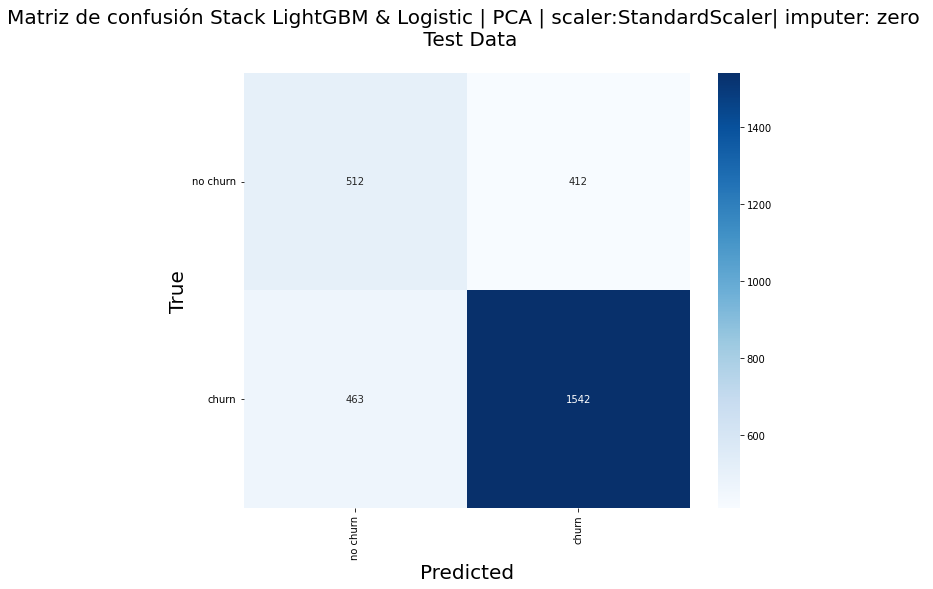

In [29]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),pred_stack(test.drop(columns=["churn","Asegurado__c"]),False),class_names=['no churn','churn'],title="Matriz de confusión Stack LightGBM & Logistic | PCA | scaler:StandardScaler| imputer: zero \n Test Data\n")

## Resumir métricas de desempeño

In [30]:
results_df=pd.DataFrame([(k,k1,v1['kappa'],v1['accuracy'],v1['prec'],v1['f1'],v1['recall'],v1['specificity']) for k,v in results.items() for k1,v1 in v.items()],columns=['model','etapa','kappa','accuracy','precision','f1','recall','specificity'])
results_df=results_df.melt(id_vars=['model','etapa'],value_vars=['kappa','accuracy','precision','f1','recall','specificity'],value_name="valor",var_name="Métrica")

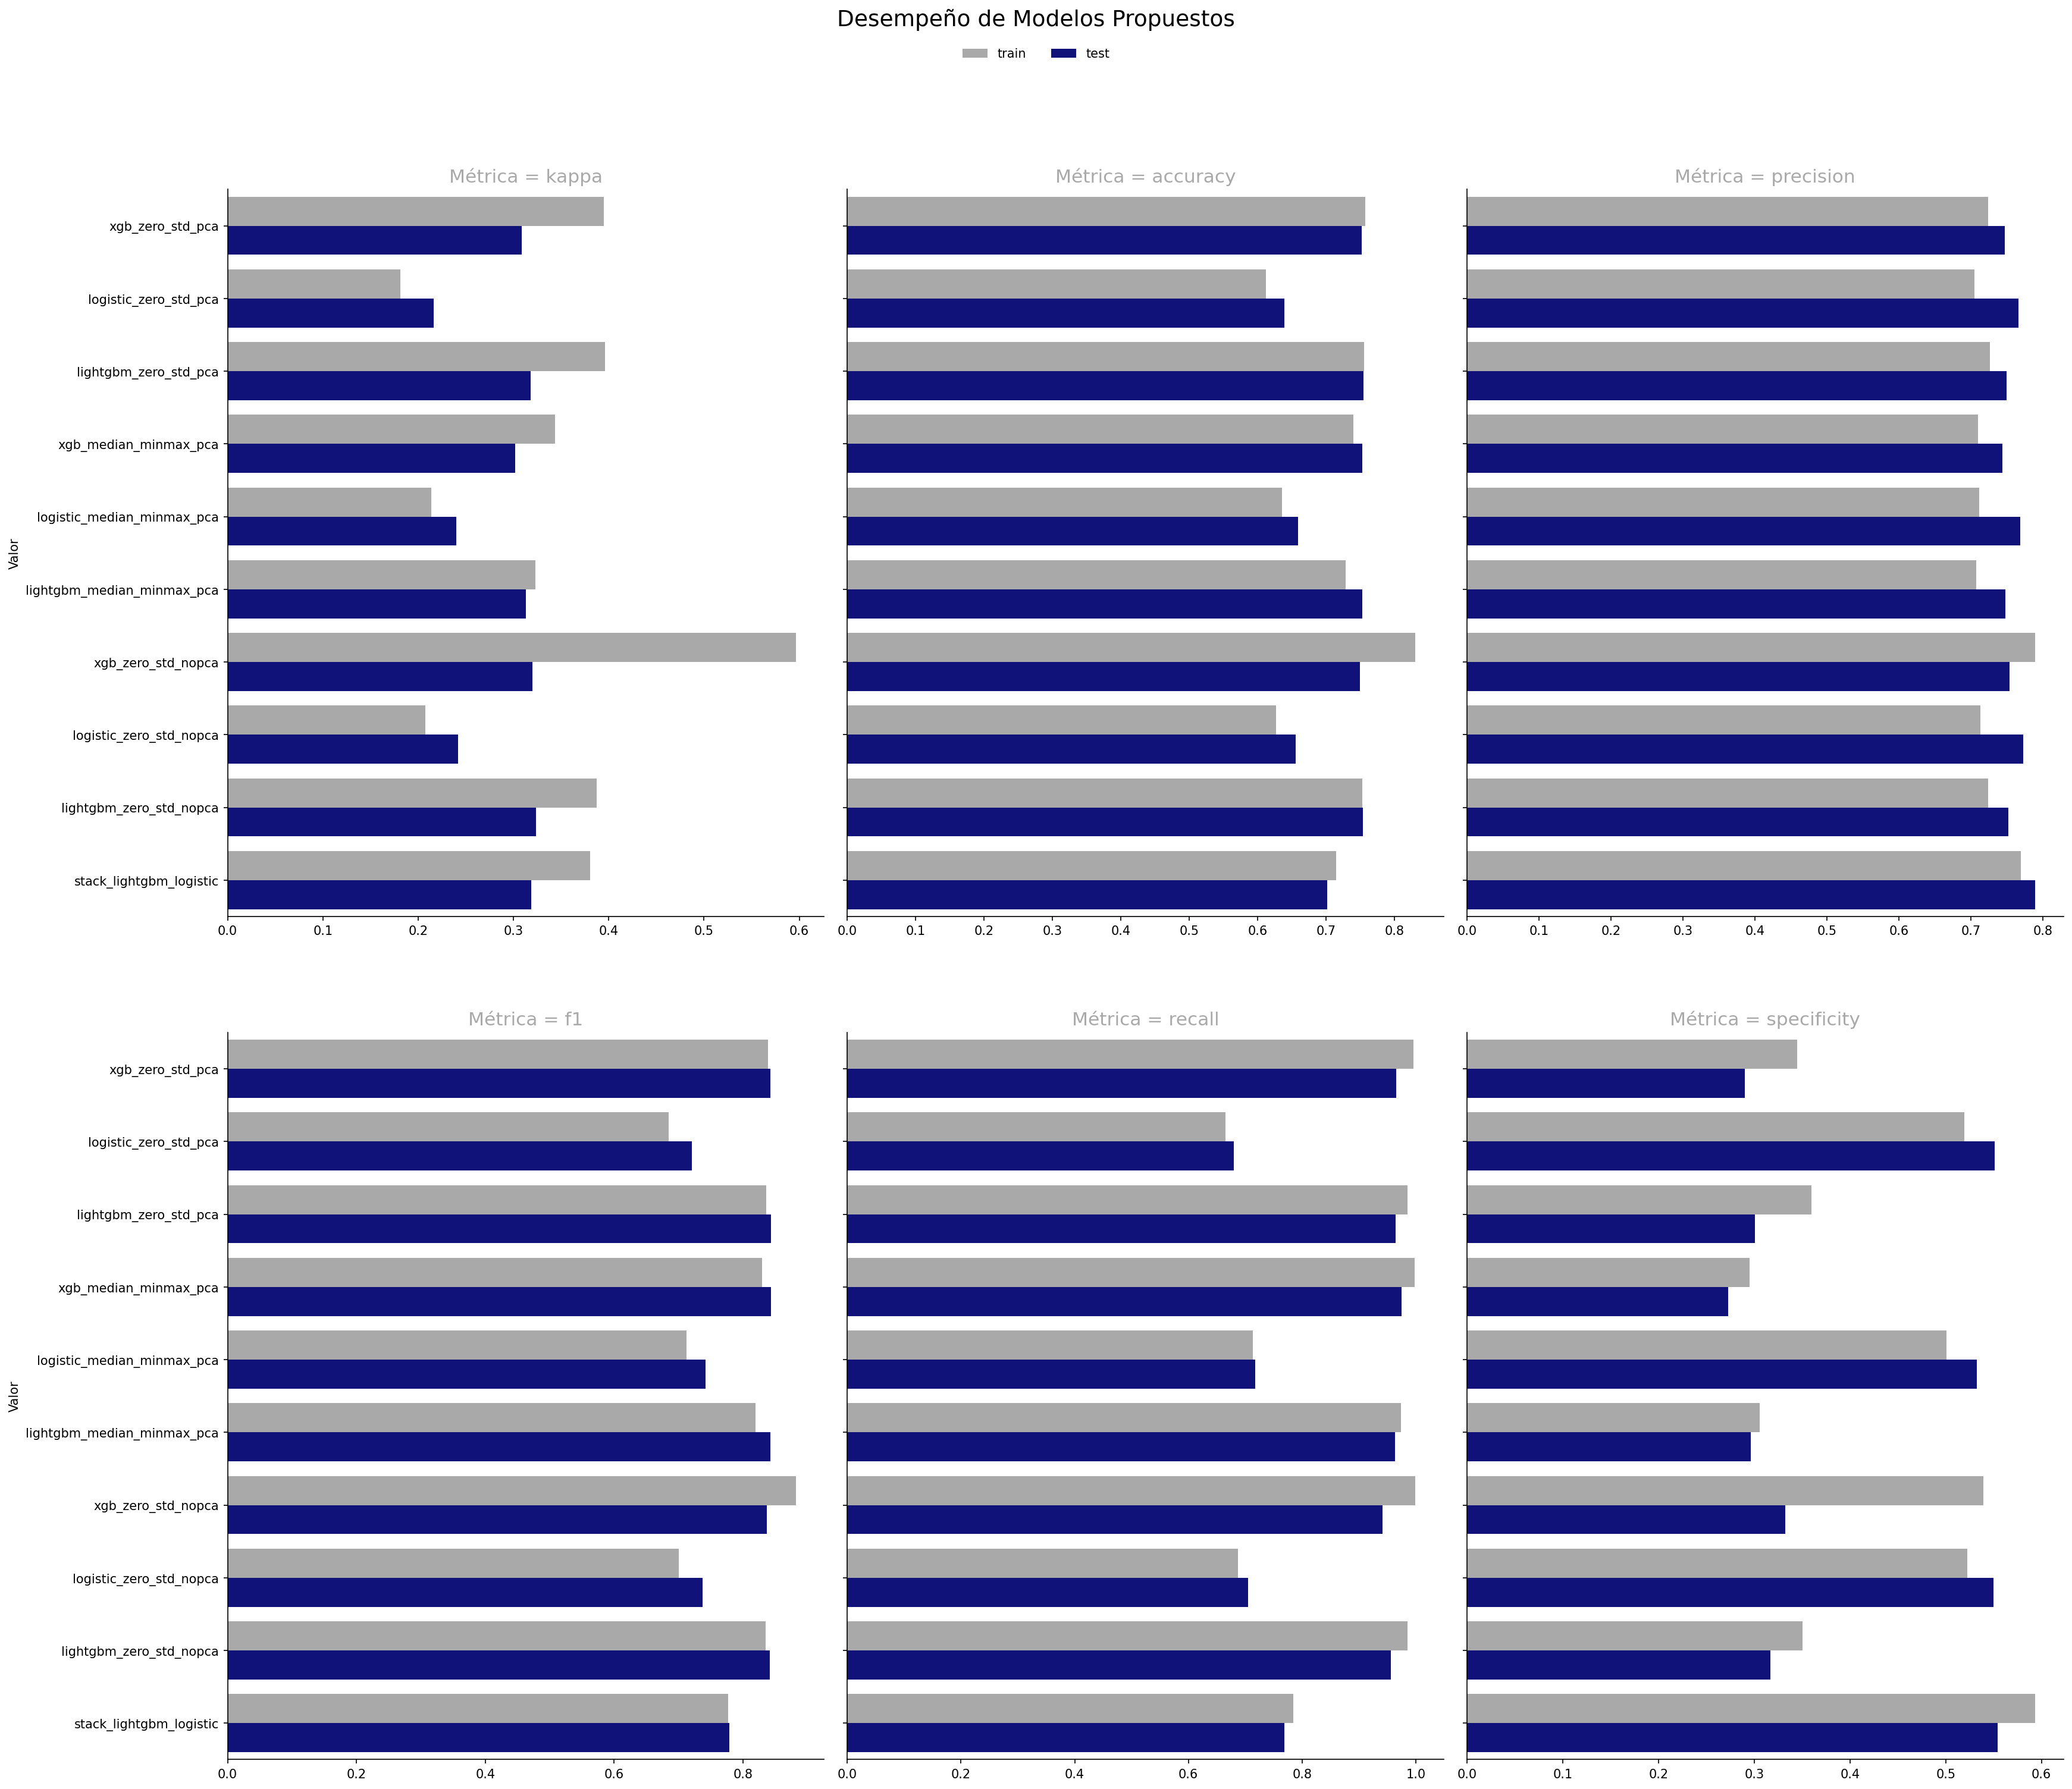

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
g=sns.catplot(y="model", x="valor", col="Métrica",hue="etapa",kind="bar",legend=True,
                data=results_df,col_wrap=3,sharex=False,aspect=1.5,orient="h",palette={'train':'darkgray','test':'darkblue'})
for i in g.axes:
    i.set_ylabel("Valor")
    i.set_title(i.get_title(),size=15)
    i.title.set_color("darkgray")
    #i.set_xticklabels(i.get_xticklabels(), rotation=90)
    i.set_xlabel("\n")
g.figure.suptitle("Desempeño de Modelos Propuestos", y=1.02,size=18);
g.fig.tight_layout()
g.fig.set_figheight(20)
g.fig.set_dpi(150)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(0.5, 0.985),
    ncol=2,
    title=None, frameon=False
)
g.savefig('models/models_performance.png')

## Discusión

- La selección del mejor modelo dependerá de las necesidades de negocio. Sin embargo, en cuanto a especificidad, la regresión logística sin reducción de dimensionalidad(PCA), imputación de ceros en variables numéricas y standardScaler obtuvo el mejor desempeño. Por otro, lado fue la de peor recall y score F1. 

- El modelo más robusto de los propuestos, si se desea detectar el churn principalmente, en términos de precisión, score f1 y kappa fue el stacking de modelos LightGBM y Regresión Logística (con reducción de dimensionalidad(PCA), imputación de ceros y standardScaler). Sin embargo, cabe la posibilidad de explorar modelos adicionales o mas hiperparámetros de los modelos propuestos.

- Existen otras posibilidades de exploración en cuanto a encontrar el mejor modelo, y es hacer un análisis con diferentes puntos de corte para la probabilidad. Actualmente para los modelos logísticos, se asume el churn si la probabilidad que arroja el modelo es mayor a 0.5. Sin embargo, este valor puede modificarse para evaluar el comportamiento de las métricas con puntos de corte diferentes.

- Otro aspecto a explorar son los problemas de desbalanceo de datos. En este caso una mejora podría obtenerse al utilizar técnicas de downsampling o oversampling como SMOTE o Adasyn y reentrenar los modelos. Sin embargo esto sugiere un mayor tiempo de preprocesamiento y entrenamiento.


### Exportar modelos para futuro uso

In [33]:
import pickle
import os

if not os.path.isdir("models"):
    os.mkdir("models")

with open("models/xgbmodel.pickle","wb") as f:
    pickle.dump(xgb,f)

with open("models/logistic.pickle","wb") as f:
    pickle.dump(logistic,f)

with open("models/lightgbm.pickle","wb") as f:
    pickle.dump(lightgbm,f)

with open("models/xgbmodel2.pickle","wb") as f:
    pickle.dump(xgb_2,f)

with open("models/logistic2.pickle","wb") as f:
    pickle.dump(logistic_2,f)

with open("models/lightgbm2.pickle","wb") as f:
    pickle.dump(lightgbm_2,f)

with open("models/xgbmodel_nopca.pickle","wb") as f:
    pickle.dump(xgb_nopca,f)

with open("models/logistic_nopca.pickle","wb") as f:
    pickle.dump(logistic_nopca,f)

with open("models/lightgbm_nopca.pickle","wb") as f:
    pickle.dump(lightgbm_nopca,f)


In [4]:
##reutilizar | leer modelos guardados
import pickle
with open("models/logistic_2.pickle", 'rb') as f:
    logistic_2 = pickle.load(f)